In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import Subset

bs = 100
# MNIST Dataset
#train_dataset = datasets.MNIST(root='/root/data/', train=True, transform=transforms.ToTensor(), download=True)
train_dataset = datasets.MNIST(root='/root/data/', train=True, transform=transforms.ToTensor(), download=False)
#test_dataset = datasets.MNIST(root='/root/data/', train=False, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='/root/data/', train=False, transform=transforms.ToTensor(), download=False)

train_subset_indices = range(1000)
train_dataset = Subset(train_dataset, train_subset_indices)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=True)

In [2]:
import torch
import torch.nn as nn


class VAE(nn.Module):

    def __init__(self, input_size, hidden_size, latent_dim) -> None:
        super().__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_dim)
        self.fc22 = nn.Linear(hidden_size, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        #encoded = self.encoder(x)
        encoded = torch.flatten(x, 1)
        encoded = torch.tanh(self.fc1(encoded))
        mean = self.fc21(encoded)
        logvar = self.fc22(encoded)
        eps = torch.randn_like(logvar)
        std = torch.exp(logvar / 2)
        z = eps * std + mean
        x = torch.tanh(self.fc3(z))
        x = torch.sigmoid(self.fc4(x))
        x = torch.reshape(x, (-1, 1, 28, 28))
        decoded = x
        return mean, logvar, decoded


In [7]:
learning_rate = 3e-3
input_size = 784
hidden_size = 100
latent_size = 3
from time import time

n_epochs = 60000

def compute_elbo(x, reconst_x, mean, log_var):
    reconst_error = -torch.nn.functional.binary_cross_entropy(reconst_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    elbo = (reconst_error - kl_divergence) / len(x)
    return elbo

def compute_mlikelihood_slow(x, x_hat, mean, logvar, model):
    for param in model.parameters():
        param.data = param.data.double()
    model.eval()
    with torch.no_grad():
        mlikelihood = 0
        for i in range(len(x)):
            x_i = x[i].double()
            x_hat_i = x_hat[i].double()
            mean_i = mean[i].double()
            logvar_i = logvar[i].double()
            sampler = torch.distributions.MultivariateNormal(mean_i, torch.diag(torch.exp(logvar_i)))
            mc_sum = 0
            for _ in range(50):
                z = sampler.sample()
                y = torch.tanh(model.fc3(z))
                y = torch.sigmoid(model.fc4(y))
                y = torch.reshape(y, (1, 28, 28))
                mc = torch.exp(-torch.sum(logvar_i)/2 - torch.sum((mean_i-z)**2/torch.exp(logvar_i))/2 - torch.sum(z**2)/2 + F.binary_cross_entropy(y, x_i, reduction='sum'))
                mc_sum += mc
            mlikelihood += torch.log(50/mc_sum).item()
        return mlikelihood/len(x)

def compute_mlikelihood(x, mean, logvar, model):
    x = torch.reshape(x, (-1,28*28)).double()
    mean = mean.double()
    logvar = logvar.double()
    for param in model.parameters():
        param.data = param.data.double()
    model.eval()
    with torch.no_grad():
        
        std = torch.exp(logvar/2)
        Z = torch.normal(mean.repeat(50, 1, 1), std.repeat(50, 1, 1))
        Z = torch.reshape(Z, (50*len(mean), -1))
        Y = torch.tanh(model.fc3(Z))
        Y = torch.sigmoid(model.fc4(Y))
        Y = torch.reshape(Y, (-1, 28*28))
        Y = torch.reshape(Y, (50, len(mean), 28*28))
        Z = torch.reshape(Z, (50, len(mean), -1))
        
        mlikelihood = torch.mean( torch.exp(-torch.sum(logvar, 1)/2 - torch.sum((mean-Z)**2/torch.exp(logvar), 2)/2 - torch.sum(Z**2, 2)/2 + torch.sum(F.binary_cross_entropy(Y, x.repeat(50, 1, 1), reduction='none'), 2)), 0)    
        mlikelihood = torch.mean(-torch.log(mlikelihood))
        
        return mlikelihood.item()
    

def train(device, model, latent_dim):
    print(latent_dim)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    begin_time = time()
    # train
    loss_list = []
    with open('/root/paper/mlikelihood/mnist_small.txt', 'w') as file:
        for i in range(n_epochs):
            loss_sum = 0
            for batch_idx, (x, _) in enumerate(train_loader):
                x = x.to(device)
                mean, logvar, x_hat = model(x)
                loss = -compute_elbo(x, x_hat, mean, logvar)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                #loss_sum += loss.item()*len(x)
                #if batch_idx % 100 == 0:
                #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(i, batch_idx * len(x), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))

            # estimate mlikelihood
            if(i % 100 == 0):
                model.eval()
                with torch.no_grad():
                    each_epoch = 1
                    n_samples = 1000
                    double_model = VAE(input_size, hidden_size, latent_size).to(device)
                    double_model.load_state_dict(model.state_dict())
                    #train
                    indices = torch.randperm(len(train_dataset))[:n_samples]
                    x = torch.stack([train_dataset[i][0] for i in indices]).to(device)
                    mean, logvar, x_hat = model(x)
                    mlikelihood = compute_mlikelihood(x, mean, logvar, double_model)
                    print('====> Epoch: {} mlikelihood: {:.4f}'.format(i, mlikelihood))
                    file.write(str(mlikelihood) + ' ')
                    #test
                    indices = torch.randperm(len(test_dataset))[:n_samples]
                    x = torch.stack([test_dataset[i][0] for i in indices]).to(device)
                    mean, logvar, x_hat = model(x)
                    mlikelihood = compute_mlikelihood(x, mean, logvar, double_model)
                    print('====> Epoch: {} mlikelihood: {:.4f}'.format(i, mlikelihood))
                    file.write(str(mlikelihood) + '\n')
                    del double_model
            
                training_time = time() - begin_time
                minute = int(training_time // 60)
                second = int(training_time % 60)
                print(f'time loss {minute}:{second}')
            
            torch.cuda.empty_cache()
        
    tot_training_time = time() - begin_time
    minute = int(tot_training_time // 60)
    second = int(tot_training_time % 60)
    print(f'total time loss {minute}:{second}')

def initialize_parameters(model):
    for param in model.parameters():
        param.data.normal_(mean=0, std=0.01)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
        
def moving_average(data, window_size):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean().values

def drawing():
    plt.clf()
    fig = plt.figure(figsize=(3, 3))
    trains = []
    tests = []
    with open('/root/paper/mlikelihood/mnist_small.txt', 'r') as file:
        for line in file:
            parts = line.split()
            trains.append(float(parts[0]))
            tests.append(float(parts[1]))
            
    epochs = [i / 10 for i in range(1, len(trains) + 1)]
    
    trains_smoothed = moving_average(trains, 20)
    tests_smoothed = moving_average(tests, 20)

    plt.plot(epochs, tests_smoothed, label='Test')
    plt.plot(epochs, trains_smoothed, label='Train')

    plt.xlabel('Samples (Millions)')
    plt.ylabel('Marginal Likelihood')
    plt.title('N = 1000')
    plt.legend()
    plt.ylim(-200, -100)
    #plt.xlim(1, 1e7)
    plt.savefig('/root/paper/mlikelihood/pictures/mnist_small.png',bbox_inches='tight')
    plt.show()

In [ ]:
def main():
    device = 'cuda:0'

    #model = VAE(latent_dim = 10).to(device)

    # Load the model
    #model = torch.load('/root/VAE/VAE_model.pth', map_location=device)

    #Choose which to play
    model = VAE(input_size, hidden_size, latent_size).to(device)
    initialize_parameters(model)
    train(device, model, latent_size)
    #generate(device, model)
    #reconstruct(device, model)
    #latent_space(device, model)
    #explore_latent()
    #print(sum(p.numel() for p in model.parameters() if p.requires_grad))

if __name__ == '__main__':
    main()

<Figure size 432x288 with 0 Axes>

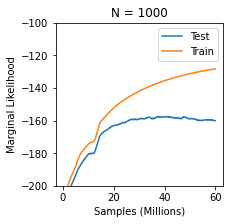

In [8]:
drawing()